# Creating Corpus

In [1]:
import os
import zipfile
import multiprocessing

from gensim.models import word2vec
from keras.utils.data_utils import get_file

Using TensorFlow backend.


# Downloading the dataset
You can download training data and evaluation data.

In [2]:
def maybe_download(url):
    """
    Download a file if not present.
    """
    filename = url.split('/')[-1]
    path = get_file(filename, url)
    return path
    

def unzip(zip_filename):
    """
    Extract a file from the zipfile
    """
    with zipfile.ZipFile(zip_filename) as f:
        for filename in f.namelist():
            dirname = os.path.dirname(filename)
            f.extract(filename, dirname)
            return os.path.abspath(filename)
            

url = 'http://mattmahoney.net/dc/text8.zip'
filename = maybe_download(url)
text_file = unzip(filename)

# Training the Model
You can read training data from a text file using the word2vec.Text8Corpus class.
By default, it assumes that the text file is given.
Now, we obtained skip-gram model. Let's train it by calling train_on_batch and passing training examples:

In [5]:
sentences = word2vec.Text8Corpus(text_file)
window_sizes = [1, 2, 4, 8, 16]
model_names = {}
for window_size in window_sizes:
    print('Starting training with window size {}...'.format(window_size))
    out_model = "text8.ws{}.txt".format(window_size)
    model_names[window_size] = out_model  # TODO: {window_size: model_name} or [window_size,...]
    model = word2vec.Word2Vec(sentences, size=200, sg=1, window=window_size, workers=multiprocessing.cpu_count())
    model.wv.save_word2vec_format(out_model)
    # model.save(out_model)
    print('Finished')

Starting training with window size 1...


Finished
Starting training with window size 2...


Finished
Starting training with window size 4...


Finished
Starting training with window size 8...


Finished
Starting training with window size 16...


Finished


## Preparing the text data
First, we will simply iterate over the folders in which our text samples are stored, and format them into a list of samples. We will also prepare at the same time a list of class indices matching the samples:

In [ ]:
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                f = open(fpath)
                texts.append(f.read())
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

Then we can format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


def prepare_train_and_test_data(texts):
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)
    
    # split the data into a training set and a validation set
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
    
    x_train = data[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = data[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]
    
    return x_train, y_train, x_val, y_val

# Preparing the Embedding layer
Next, we compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:

In [ ]:
import numpy as np

def prepare_embeddings_index(file_path):
    """
    :param file_path: word vector's file path 
    :return embeddings_index: pre-trained word vectors
    embeddings_index = {'word1': [real numbers],
                        'word2': [real numbers],
                        ...,
                        'wordn': [real numbers]}
    """
    embeddings_index = {}
    with open(file_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [ ]:
def create_embedding_matrix(embeddings_index, word_index, EMBEDDING_DIM):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Building the Classifier

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


def build_model():
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features, 128, weights=[embedding_matrix], dropout=0.2))
    model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=15, validation_data=(X_test, y_test))

# Evaluation
## Evaluation of Classifier

In [ ]:
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

## Evaluation of Word Embeddings

In [30]:
import gensim.test
from gensim.models import KeyedVectors
module_path = gensim.test.__path__[0]
spearmans = []
for window_size in sorted(model_names.keys()):
    model_name = model_names[window_size]
    word_vectors = KeyedVectors.load_word2vec_format(model_name)
    _, spearman, _ = word_vectors.evaluate_word_pairs(os.path.join(module_path, 'test_data', 'wordsim353.tsv'))
    spearmans.append(spearman.correlation)
    print(spearman.correlation)

0.546604463077


0.62974217854


0.673909870363


0.711368463157


0.716476219727


## Plotting the evaluation result

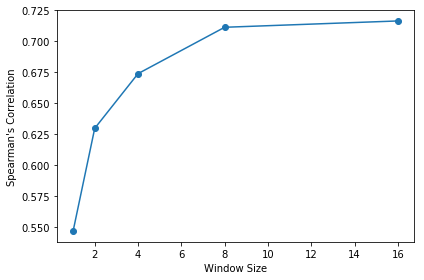

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(list(sorted(model_names.keys())), spearmans, marker='o')
plt.xlabel('Window Size')
plt.ylabel('Spearman\'s Correlation')

plt.tight_layout()
plt.show()

# Result